### Classification: Sentiment analysis on Amazon book sales reviews using scikit learn libraries

In [75]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report


In [76]:
# path = "./Books_small.json"
path = "./Books_small_10000.json"
df = pd.read_json(path, lines=True)

# reviews = []
# with open(path) as f:
#     for line in f:
#         review = json.loads(line)
#         reviews.append((review["reviewText"], review["overall"]))

In [77]:
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1F2H80A1ZNN1N,B00GDM3NQC,Connie Correll,"[0, 0]","I bought both boxed sets, books 1-5. Really a...",5,Can't stop reading!,1390435200,"01 23, 2014"
1,AI3DRTKCSK4KX,B00A5MREAM,Grandma,"[0, 0]",I enjoyed this short book. But it was way way ...,3,A leaf on the wind of all hallows,1399593600,"05 9, 2014"
2,A3KAKFHY9DAC8A,0446547573,"toobusyreading ""Inspired Kathy""","[1, 1]",I love Nicholas Sparks. I&#8217;ve read everyt...,4,Great writing from Nicholas Sparks.,1404518400,"07 5, 2014"


In [78]:
df.info()
rows_with_na = df[df["reviewerName"].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10000 non-null  object
 1   asin            10000 non-null  object
 2   reviewerName    9957 non-null   object
 3   helpful         10000 non-null  object
 4   reviewText      10000 non-null  object
 5   overall         10000 non-null  int64 
 6   summary         10000 non-null  object
 7   unixReviewTime  10000 non-null  int64 
 8   reviewTime      10000 non-null  object
dtypes: int64(2), object(7)
memory usage: 703.3+ KB


In [79]:
reviews = df[["reviewText", "overall"]]

def map_sentiment(overall):
    if overall <= 2:
        return "NEGATIVE"
    else:
        return "POSITIVE" 
    
reviews["sentiment"] = df["overall"].apply(lambda x: map_sentiment(x))

display(reviews.head())

C:\Users\PC\AppData\Local\Temp\ipykernel_6716\1689989726.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews["sentiment"] = df["overall"].apply(lambda x: map_sentiment(x))


,reviewText,overall,sentiment
0,"I bought both boxed sets, books 1-5. Really a...",5,POSITIVE
1,I enjoyed this short book. But it was way way ...,3,POSITIVE
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4,POSITIVE
3,I really enjoyed this adventure and look forwa...,4,POSITIVE
4,It was a decent read.. typical story line. Not...,3,POSITIVE


#### Evenly Distributing the data

In [80]:
print(reviews["sentiment"].value_counts())

sentiment
POSITIVE    9356
NEGATIVE     644
Name: count, dtype: int64


In [81]:
n_samples = reviews["sentiment"].value_counts()["NEGATIVE"]

# random sampling 
positive = reviews[reviews["sentiment"] == "POSITIVE"].sample(n=n_samples, random_state= 23)
negative = reviews[reviews["sentiment"] == "NEGATIVE"].sample(n=n_samples, random_state= 23)

# concatenate and shuffle the index number 
reviews = pd.concat([positive,negative])
reviews = reviews.sample(frac=1).reset_index(drop=True)

print(reviews["sentiment"].value_counts())
reviews.head()

sentiment
NEGATIVE    644
POSITIVE    644
Name: count, dtype: int64


,reviewText,overall,sentiment
0,I couldn't get through it and couldn't discern...,1,NEGATIVE
1,This is an action packed rapid paced book 5 of...,5,POSITIVE
2,"Seduction was extremely short, even for a PWP....",3,POSITIVE
3,"Tris is amazing. She's human, and that's what ...",5,POSITIVE
4,I read this book as it was part of the collect...,1,NEGATIVE


#### Data preparation: Feature extraction with `Bag of words`

In [82]:
features = "reviewText"
target = "sentiment"

x = reviews[features]
y = reviews[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=240)

##### Bag of words

In [83]:
# (row document, no of occurrence for each unique word) 
# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer() #if the word appears a lot (common word), the weight would be lower (less important)

# fit_transform train data
x_train_vectors = vectorizer.fit_transform(x_train)

# transform test data
x_test_vectors = vectorizer.transform(x_test)


#### Classification

##### Linear SVM

In [84]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


model_svc = svm.SVC(kernel='linear')
model_svc.fit(x_train_vectors, y_train)
model_svc.predict(x_test_vectors);

##### Decision Trees

In [85]:
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train_vectors, y_train)
model_dt.predict(x_test_vectors);

##### Naive Bayes

In [86]:
model_gnb = GaussianNB()
model_gnb.fit(x_train_vectors.toarray(), y_train)
model_gnb.predict(x_test_vectors.toarray());

##### Logistic Regression

In [87]:
model_lr = LogisticRegression(max_iter=500)
model_lr.fit(x_train_vectors, y_train)
model_lr.predict(x_test_vectors);

##### Evaluation

In [88]:
models = [model_svc, model_dt, model_gnb, model_lr]

for model in models:
    print(f"Model Name: {type(model).__name__}")
    print(classification_report(y_test, model.predict(x_test_vectors.toarray())))

Model Name: SVC
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.83      0.80       213
    POSITIVE       0.82      0.77      0.79       213

    accuracy                           0.80       426
   macro avg       0.80      0.80      0.80       426
weighted avg       0.80      0.80      0.80       426

Model Name: DecisionTreeClassifier
              precision    recall  f1-score   support

    NEGATIVE       0.65      0.61      0.63       213
    POSITIVE       0.63      0.67      0.65       213

    accuracy                           0.64       426
   macro avg       0.64      0.64      0.64       426
weighted avg       0.64      0.64      0.64       426

Model Name: GaussianNB
              precision    recall  f1-score   support

    NEGATIVE       0.66      0.60      0.63       213
    POSITIVE       0.63      0.69      0.66       213

    accuracy                           0.64       426
   macro avg       0.64      0.64      0.64       426


In [89]:
# f1 score for "NEUTRAL" and "NEGATIVE" is low -> 0.09
# print(reviews["sentiment"].value_counts())

# the dataset is lack of "NEUTRAL" & "NEGATIVE" reviews for training
# use "Books_small_10000.json" for more data set, and evenly distribute it

In [90]:
test_set = ["good book", "worth it if bought during discount", "not bad but do not recommend"]
test_set_vect = vectorizer.transform(test_set)

model_svc.predict(test_set_vect)

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE'], dtype=object)

#### Tuning our model (with Grid Search)

In [91]:
# testing bunch of different parameters required for the model
from sklearn.model_selection import GridSearchCV

parameters = {
    "kernel": ('linear', 'rbf'),
    "C" : (1,4,8,16,32)
}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(x_train_vectors, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

In [92]:
print(f"New Accuracy: {clf.score(x_test_vectors, y_test)*100:.2f}%")

New Accuracy: 81.69%


#### Saving & Loading Model 

In [93]:
# alternatively, use pickle
from joblib import dump, load

dump(clf, "./sentiment_classifier.joblib")
dump(vectorizer, "./sentiment_vectorizer.joblib")


['./sentiment_vectorizer.joblib']

In [94]:
load_model = load("sentiment_classifier.joblib")

In [95]:
load_model.predict(test_set_vect)

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE'], dtype=object)

#### Prediction visualization

<Axes: >

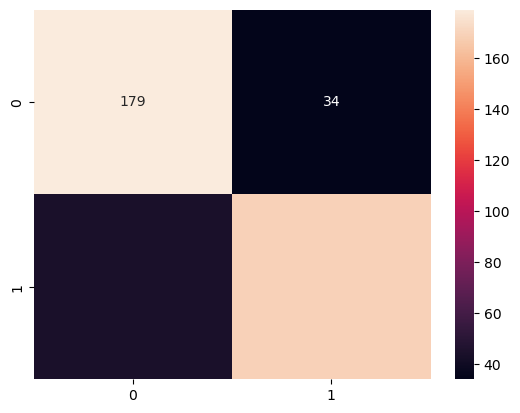

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_prediction = load_model.predict(x_test_vectors)
labels = ["NEGATIVE", "POSITIVE"]

cm = confusion_matrix(y_test, y_prediction, labels=labels)

sns.heatmap(cm, annot=True, fmt="d")